<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/7_Linear_multiclass_classification/7_6_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 7: Linear multi-class classification

This notebook contains interactive content from an early draft of the university textbook <a href="https://github.com/neonwatty/machine-learning-refined/tree/main">
Machine Learning Refined (2nd edition) </a>.

The final draft significantly expands on this content and is available for <a href="https://github.com/neonwatty/machine-learning-refined/tree/main/chapter_pdfs"> download as a PDF here</a>.

# 7.6  Classification Quality Metrics

In this Section we describe simple metrics for judging the quality of a trained multi-class classification model, as well as how to make predictions using one.

In [1]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone datasets
if not Path('chapter_7_library').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/7_Linear_multiclass_classification/chapter_7_library
else:
    print('chapter_7_library already cloned!')

# clone library subdirectory
if not Path('chapter_7_datasets').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/7_Linear_multiclass_classification/chapter_7_datasets
else:
    print('chapter_7_datasets already cloned!')

# clone datasets
if not Path('chapter_7_images').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/7_Linear_multiclass_classification/chapter_7_images
else:
    print('chapter_7_images already cloned!')
        
# append path for local library, data, and image import
import sys
sys.path.append('./chapter_7_library') 

# import section helper
import section_7_4_helpers

# dataset paths
dataset_path_1 = 'chapter_7_datasets/5class_data.csv'

# image paths
image_path_1 = "chapter_7_images/multiclass_prediction.png"
image_path_2 = "chapter_7_images/confusion_multiclass.png"


# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_7_library already cloned!
chapter_7_datasets already cloned!
chapter_7_images already cloned!


## Making predictions using a trained model

If we denote the optimal set of weights found by minimizing a classification cost function (or via performing OvA), employing by default label values $y_p \in \left\{0,1,...,C-1\right\}$, by $\mathbf{W}^{\star}$ then note we can write our fully tuned linear model as 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{W}^{\star}\right) =  \mathring{\mathbf{x}}_{\,}^T\mathbf{W}^{\star}   
\end{equation}

This fully trained model defines an optimal decision boundary for the training dataseet which is defined by the fusion rule

\begin{equation}
\underset{c=0,...,C-1}{\text{argmax}}\,\, \mathbf{x}^T \mathbf{w}_c^{\star}.
\end{equation}

To predict the label $y$ of an input $\mathbf{x}$ we then process it through this rule as

\begin{equation}
y_{\,} = \underset{c=0,...,C-1}{\text{argmax}}\,\, \mathbf{x}^T \mathbf{w}_c^{\star} 
\end{equation}

where any point lying *exactly* on the decision boundary should be assigned a label randomly based on the index of those classifiers providing maximum evaluation.

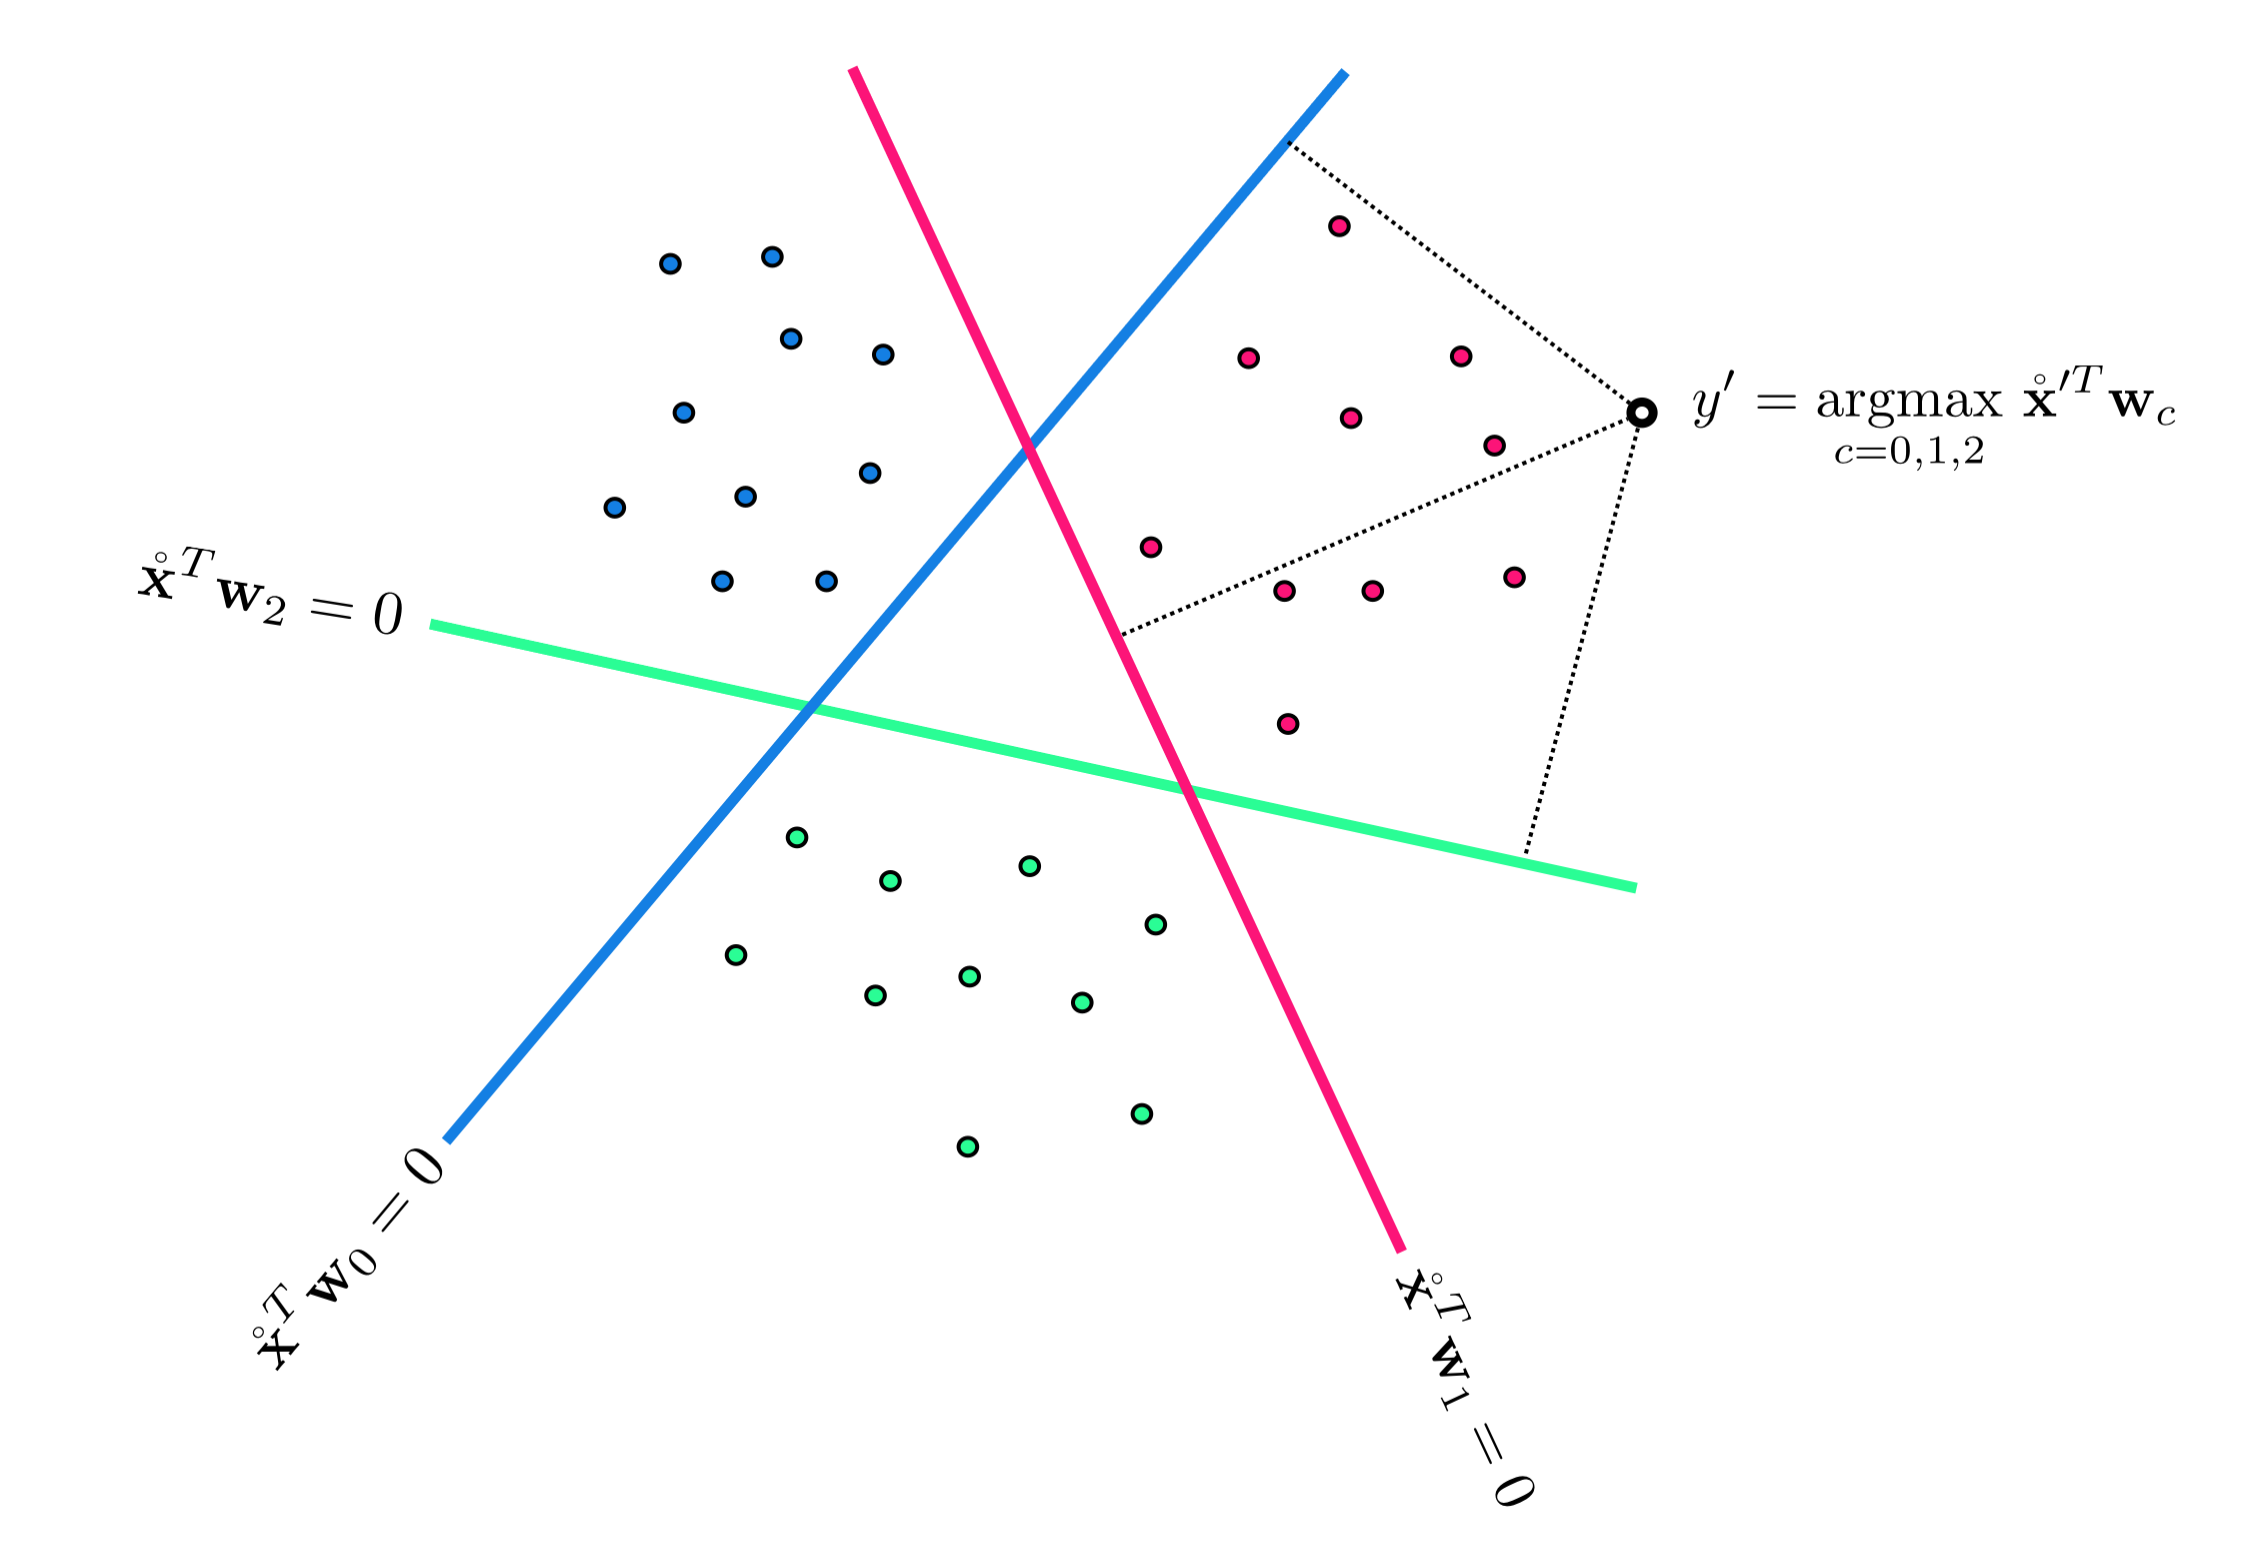

In [2]:
Image(image_path_1)

<figure>
  <figcaption>   
<strong></strong> <em> 

</em>  </figcaption> 
</figure>

##  Confidence scoring

Once a proper decision boundary is learned, we can judge its *confidence* in any point based on *the point's distance to the decision boundary*.  More specifically we can its the exponentially normalized distance to score our confidence in the prediction, as described in [Section 7.5.3](https://jermwatt.github.io/machine_learning_refined/notes/7_Linear_multiclass_classification/7_5_Categorical.html).

##  Judging the quality of a trained model using *accuracy*

To *count the number of misclassifications* a trained multi-class classifier forms over our training dataset we simply take a raw count of the number of training datapoints $\mathbf{x}_p$ whose true label $y_p$ is predicted *incorrectly*.   To compare the point $\mathbf{x}_p$'s predicted label $\hat{y}_p =  \underset{j=0,...,C-1}{\text{argmax}}\,\, \mathbf{x}_p^T \mathbf{w}_j^{\star} $ and true true label $y_p$ we can use an identity function $\mathcal{I}\left(\cdot\right)$ and compute

\begin{equation}
\mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right) = 
\begin{cases}
0 \,\,\,\,\,\text{if} \,\, \hat{y}_p,= \overset{\,}{y}_p \\
1 \,\,\,\,\,\text{if} \,\,  \hat{y}_p,\neq \overset{\,}{y}_p. \\
\end{cases}
\end{equation}

Summing all $P$ points gives the total number of misclassifications of our trained model


\begin{equation}
\text{number of misclassifications} = \sum_{p=1}^P \mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right).
\end{equation}

Using this we can also compute the *accuracy*  - denoted $\mathcal{A}$ - of a trained model.  This is simply the percentage of training dataset whose labels are correctly predicted by the model.

\begin{equation}
\mathcal{A}= 1 - \frac{1}{P}\sum_{p=1}^P \mathcal{I}\left(\hat{y}_p,\,\overset{\,}{y}_p\right).
\end{equation}

The accuracy ranges from 0 (no points are classified correctly) to 1 (all points are classified correctly).  

#### <span style="color:#a50e3e;">Example 6: </span> Comparing cost function and counting cost values

Below we compare the number of misclassifications versus the multi-class softmax cost with regularizer. In this instance $\lambda = 10^{-5}$ for three runs of unnormalized gradient descent using a steplength parameter $\alpha = 10^{-2}$ for all three runs.

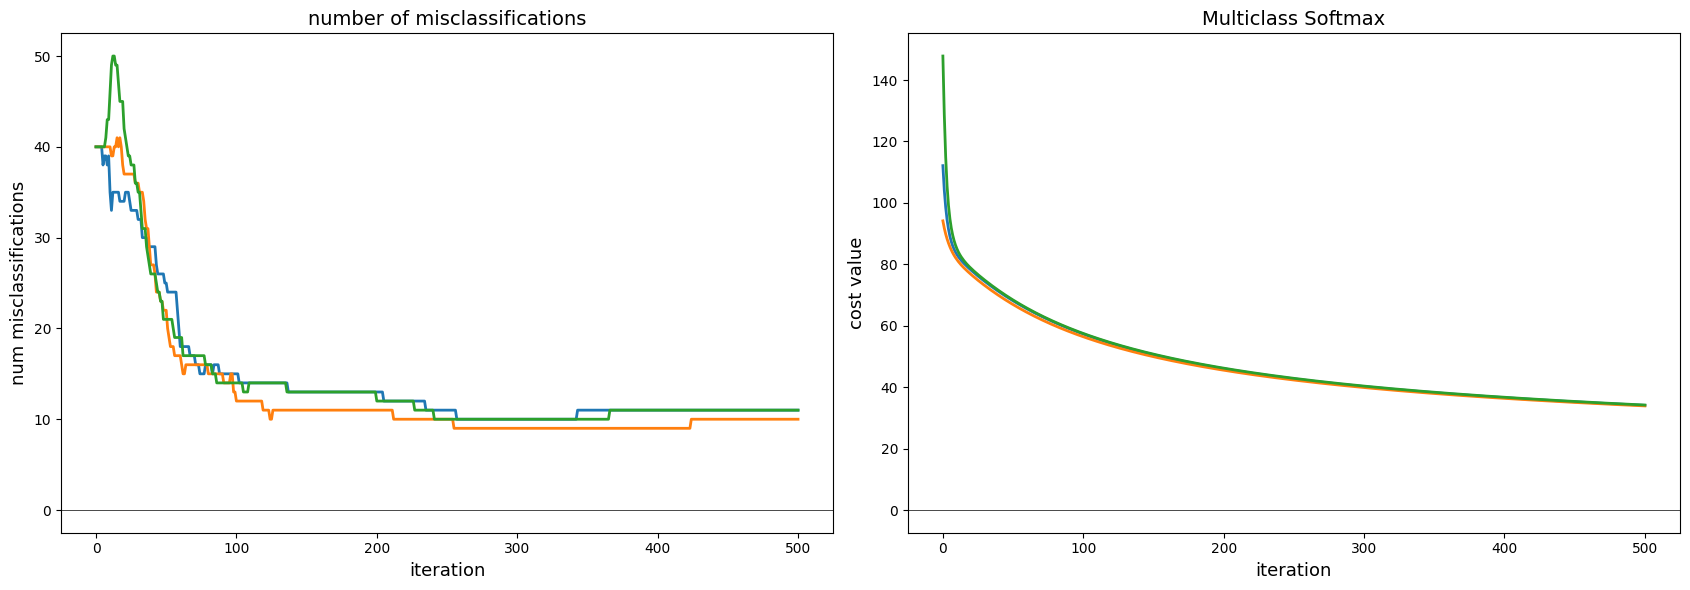

In [3]:
# load in dataset
data = np.loadtxt(dataset_path_1,delimiter = ',')

# create an instance of the ova demo
demo = section_7_4_helpers.MulticlassVisualizer(data)

# run demo
demo.compare_to_counting(num_runs = 3,max_its = 500,alpha = 10**(-2),lam = 10**(-5))

Comparing the left and right panels we can see that the number of misclassifications and Softmax evaluations at each step of a gradient descent run do not perfectly track one another.  That is, it is not the case that just because the cost function value is decreasing that so too is the number of misclassifications. Again, this occurs because our Softmax cost is only an approximation of the true quantity we would like to minimize.  

This simple example an extremely practical implication: after a running a local optimization to minimize a two-class classification cost function the best step, and corresponding weights, are associated with the lowest *number of misclassifications* (or likewise the *highest accuracy*) **not** the lowest cost function value.

## The confusion matrix and additional quality metrics

We can generalize the idea of a confusion matrix, introduced in [Section 6.8](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_8_Metrics.html) for two-class classification problems, to form such matrices for problems with arbitrary number of classes. In general the confusion matrix associated to a classification problem with $C\geq2$ classes will be of size $C\times C$, whose $\left(i,j\right)^{\textrm{th}}$
entry is the number of data points that have $y=i$ and $\hat{y}=j$.  The Figure below shows the confusion matrix computed for the four-class classifier previously in e.g., [Section 7.2](https://jermwatt.github.io/machine_learning_refined/notes/7_Linear_multiclass_classification/7_2_OvA.html).

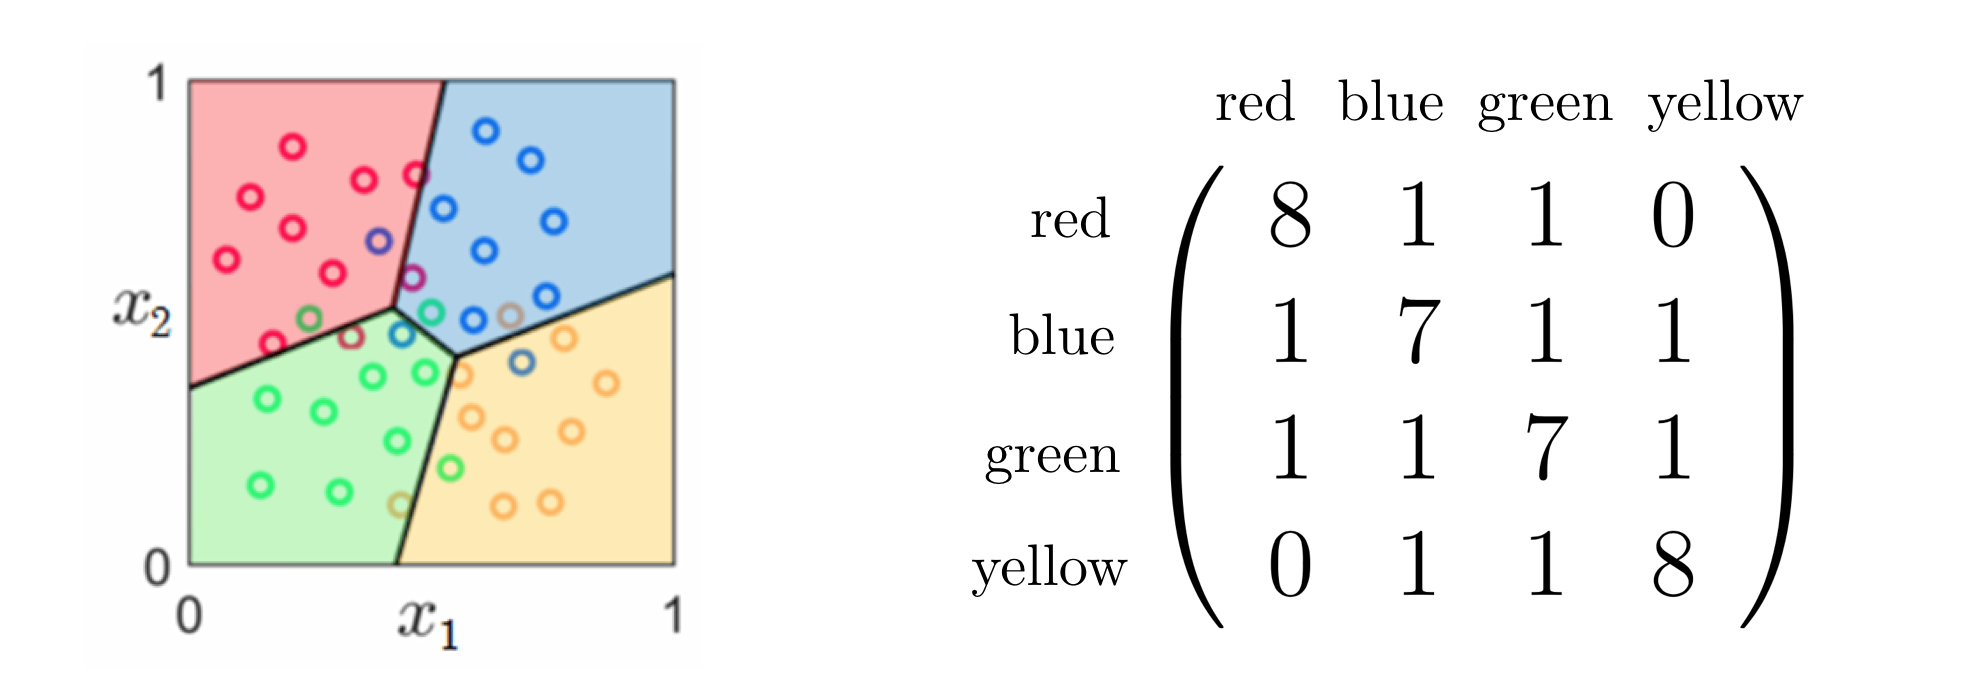

In [4]:
Image(image_path_2)

<figure>
  <figcaption>   
<strong></strong> <em>  </em>  </figcaption> 
</figure>